
# Nombre: Oscar Esaú Peralta Rosales
## Procesamiento de Lenguaje Natural
## Práctica 5: Análisis de Sentimiento con Pytorch

In [100]:
!pip install gdown

In [101]:
!gdown https://drive.google.com/uc?id=1s6GHsf5da8iy4LNJoqQGdnSktGS7eVH1

Downloading...
From: https://drive.google.com/uc?id=1s6GHsf5da8iy4LNJoqQGdnSktGS7eVH1
To: /content/imdb.zip
85.1MB [00:00, 271MB/s]


In [102]:
!unzip -qq imdb.zip

replace test/neg/0_2.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### BoW + NN (Sentiment Analysis)

In [0]:
from os import listdir
from os.path import isfile, join
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
import re

import random
import torch

path_train_pos="train/pos/"
path_train_neg="train/neg/"

train_pos = [f for f in listdir(path_train_pos) if isfile(join(path_train_pos, f))]
train_neg = [f for f in listdir(path_train_neg) if isfile(join(path_train_neg, f))]

path_test_pos="test/pos/"
path_test_neg="test/neg/"

test_pos = [f for f in listdir(path_test_pos) if isfile(join(path_test_pos, f))]
test_neg = [f for f in listdir(path_test_neg) if isfile(join(path_test_neg, f))]

In [0]:
def normalize(line):
    line=re.sub('[^A-Za-z0-9<>]+', ' ', line)
    return line.lower()

In [0]:
def build_dataset(pos, neg, path_pos, path_neg):
    data=[]
    label=[]
    for p in pos:
        txt=open(path_pos+p, "r").read()
        data.append(normalize(txt))
        label.append(1)
    for n in neg:
        txt=open(path_neg+n, "r").read()
        data.append(normalize(txt))
        label.append(0)
    return data, label

In [0]:
x_train, y_train = build_dataset(train_pos, train_neg, path_train_pos, path_train_neg)

x_test, y_test = build_dataset(test_pos, test_neg, path_test_pos, path_test_neg)

In [0]:
train = [(t, l) for (t,l) in zip(x_train, y_train)]

In [0]:
random.shuffle(train)

In [0]:
x_train=[t[0] for t in train]
y_train=[t[1] for t in train]

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [0]:
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

y_test = torch.tensor(y_test)

In [0]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(x_train)
X_val   = vectorizer.transform(x_val)
X_test  = vectorizer.transform(x_test)

X_train = X_train.toarray()
X_train = torch.from_numpy(X_train)

X_val = X_val.toarray()
X_val = torch.from_numpy(X_val)

X_test = X_test.toarray()
X_test = torch.from_numpy(X_test)

In [0]:
batch_size = 50

In [0]:
X_train =X_train.view(-1, batch_size, 1000).float()
X_val  = X_val.view(-1, batch_size, 1000).float()
X_test = X_test.view(-1, batch_size, 1000).float()

In [0]:
y_train = y_train.view(-1, batch_size)

In [116]:
X_train.shape

torch.Size([450, 50, 1000])

### Exercise 1
Build your own neural network

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        """
          Define the layers
        """
        self.ll1 = nn.Linear(1000, 1000)
        self.ll2 = nn.Linear(1000, 100)
        self.ll3 = nn.Linear(100, 2)

    def forward(self, x):
        """
          Build your neural network

            Recommended architecture
              ReLu(Layer[in:1000, out:1000])
              ReLu(Layer[in:1000, out:100])
              Dropout(0.5)
              Layer[in:100, out:2]
        """
        x = F.relu(self.ll1(x))
        x = F.relu(self.ll2(x))
        x = F.dropout(x)
        x = self.ll3(x)

        return F.log_softmax(x, dim=1)

In [0]:
# nn.Dropout?

In [0]:
model = Model()

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterio  = nn.NLLLoss()

In [0]:
def get_f1(X, y_real):
  y_pred = []
  for x in X:
    y_pred.append(model(x).argmax(1).detach())
  y_pred = torch.cat(y_pred)
  print(max(y_real.cpu()))
  print(max(y_pred.cpu()))
  return metrics.f1_score(y_true=y_real.cpu(), y_pred=y_pred.cpu())

In [0]:
def train(X_train, y_train, X_val, y_val, model, optimizer, criterio, epochs=50):
    LOSS = []
    for e in range(epochs):
        for i, (x, y) in enumerate(zip(X_train, y_train)):     
            
            y_pred = model(x)
            loss = criterio(y_pred, y)
            loss.backward()
            optimizer.step()
            
            LOSS.append(loss.item())
            if i%200==0:
                with torch.no_grad():
                    f1 = get_f1(X_val, y_val)
                print('Epoch: %d \t Batch: %d \t Loss: %.10f \t F1_val: %.10f'%(e,i, torch.tensor(LOSS[-100:]).mean(), f1))
    return LOSS

In [124]:
LOSS = train(X_train, y_train, X_val, y_val, model, optimizer, criterio, epochs=50)

tensor(1)
tensor(1)
Epoch: 0 	 Batch: 0 	 Loss: 0.6924018264 	 F1_val: 0.5995525727
tensor(1)
tensor(1)
Epoch: 0 	 Batch: 200 	 Loss: 0.6873647571 	 F1_val: 0.7159277504
tensor(1)
tensor(1)
Epoch: 0 	 Batch: 400 	 Loss: 0.6522508264 	 F1_val: 0.8028974457
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 0 	 Loss: 0.6361072659 	 F1_val: 0.8025078370
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 200 	 Loss: 0.5450193286 	 F1_val: 0.8074824630
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 400 	 Loss: 0.4478969872 	 F1_val: 0.8184944593
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 0 	 Loss: 0.4318255484 	 F1_val: 0.8105761642
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 200 	 Loss: 0.3804836273 	 F1_val: 0.8306264501
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 400 	 Loss: 0.3511183858 	 F1_val: 0.8332703214
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 0 	 Loss: 0.3614408076 	 F1_val: 0.8343558282
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 200 	 Loss: 0.3513270617 	 F1_val: 0.8367346939
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 400 	 Loss: 0.3762246966

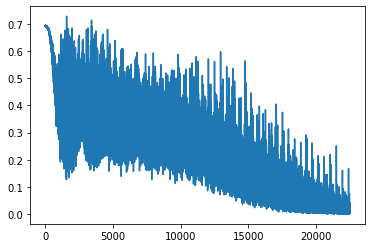

In [125]:
import matplotlib.pyplot as plt

plt.plot(LOSS)

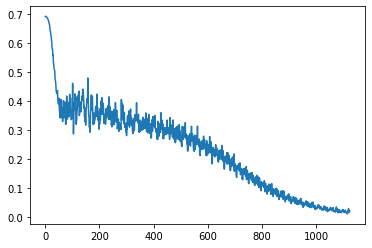

In [126]:
plt.plot(torch.tensor(LOSS).view(-1,20).mean(1))

In [127]:
print("F1_test: %.5f"%(get_f1(X_test, y_test)))

tensor(1)
tensor(1)
F1_test: 0.85006


### Exercise 2
Train your model on GPU (CUDA)

In [128]:
# Hint 1
device = torch.device("cuda:0")
model = Model().to(device)   ### Your model is in CUDA!!

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterio  = nn.NLLLoss()

# Hint 2

# If your model is in CUDA, model(x) is valid only if x is in CUDA too
X_train = X_train.cuda(0)
y_train = y_train.cuda(0)
X_val = X_val.cuda(0)
y_val = y_val.cuda(0)
X_test = X_test.cuda(0)
y_test = y_test.cuda(0)

LOSS = train(X_train, y_train, X_val, y_val, model, optimizer, criterio, epochs=50)

tensor(1)
tensor(1)
Epoch: 0 	 Batch: 0 	 Loss: 0.6958831549 	 F1_val: 0.6761980408
tensor(1)
tensor(1)
Epoch: 0 	 Batch: 200 	 Loss: 0.6891111732 	 F1_val: 0.7191307211
tensor(1)
tensor(1)
Epoch: 0 	 Batch: 400 	 Loss: 0.6586568952 	 F1_val: 0.7956656347
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 0 	 Loss: 0.6438328624 	 F1_val: 0.7883556255
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 200 	 Loss: 0.5555117726 	 F1_val: 0.8025226646
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 400 	 Loss: 0.4588294327 	 F1_val: 0.8200385356
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 0 	 Loss: 0.4404514432 	 F1_val: 0.8198903681
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 200 	 Loss: 0.3829125464 	 F1_val: 0.8311588642
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 400 	 Loss: 0.3588491678 	 F1_val: 0.8324407039
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 0 	 Loss: 0.3592201173 	 F1_val: 0.8335877863
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 200 	 Loss: 0.3466975391 	 F1_val: 0.8384644622
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 400 	 Loss: 0.3692650497

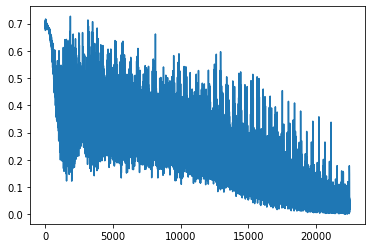

In [129]:
plt.plot(LOSS)

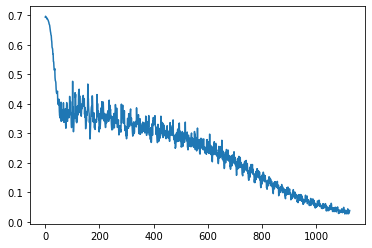

In [130]:
plt.plot(torch.tensor(LOSS).view(-1,20).mean(1))

In [131]:
print("F1_test: %.5f"%(get_f1(X_test, y_test)))

tensor(1)
tensor(1)
F1_test: 0.85465


### Exercise 3
Try a different number of features for tf-idf vectorizer and build a neural network for this data.

In [0]:
max_features = 5000

vectorizer = TfidfVectorizer(max_features=max_features)
X_train = vectorizer.fit_transform(x_train)
X_val   = vectorizer.transform(x_val)
X_test  = vectorizer.transform(x_test)

X_train = X_train.toarray()
X_train = torch.from_numpy(X_train)

X_val = X_val.toarray()
X_val = torch.from_numpy(X_val)

X_test = X_test.toarray()
X_test = torch.from_numpy(X_test)

X_train =X_train.view(-1, batch_size, max_features).float()
X_val  = X_val.view(-1, batch_size, max_features).float()
X_test = X_test.view(-1, batch_size, max_features).float()

y_train = y_train.view(-1, batch_size)

In [145]:
X_train.shape

torch.Size([450, 50, 5000])

In [0]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        """
          Define the layers
        """
        self.ll1 = nn.Linear(5000, 3000)
        self.ll2 = nn.Linear(3000, 1000)
        self.ll3 = nn.Linear(1000, 100)
        self.ll4 = nn.Linear(100, 2)

    def forward(self, x):
        """
          Build your neural network

            Recommended architecture
              ReLu(Layer[in:1000, out:1000])
              ReLu(Layer[in:1000, out:100])
              Dropout(0.5)
              Layer[in:100, out:2]
        """
        x = F.relu(self.ll1(x))
        x = F.relu(self.ll2(x))
        x = F.dropout(x)
        x = F.relu(self.ll3(x))
        x = self.ll4(x)
        return F.log_softmax(x, dim=1)

In [157]:
device = torch.device("cuda:0")
model = Model2().to(device)  

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterio  = nn.NLLLoss()

X_train = X_train.cuda(0)
y_train = y_train.cuda(0)
X_val = X_val.cuda(0)
y_val = y_val.cuda(0)
X_test = X_test.cuda(0)
y_test = y_test.cuda(0)

LOSS = train(X_train, y_train, X_val, y_val, model, optimizer, criterio, epochs=50)

tensor(1)
tensor(1)
Epoch: 0 	 Batch: 0 	 Loss: 0.6935830712 	 F1_val: 0.6761980408
tensor(1)
tensor(1)
Epoch: 0 	 Batch: 200 	 Loss: 0.6691257954 	 F1_val: 0.7719298246
tensor(1)
tensor(1)
Epoch: 0 	 Batch: 400 	 Loss: 0.3689838350 	 F1_val: 0.8413098237
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 0 	 Loss: 0.3354451060 	 F1_val: 0.8605234851
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 200 	 Loss: 0.8513044715 	 F1_val: 0.7473784557
tensor(1)
tensor(1)
Epoch: 1 	 Batch: 400 	 Loss: 0.5451791883 	 F1_val: 0.8613295211
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 0 	 Loss: 0.3450594246 	 F1_val: 0.8591261739
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 200 	 Loss: 0.4556856155 	 F1_val: 0.5844298246
tensor(1)
tensor(1)
Epoch: 2 	 Batch: 400 	 Loss: 0.4644005299 	 F1_val: 0.8445185494
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 0 	 Loss: 0.4549087882 	 F1_val: 0.8562426152
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 200 	 Loss: 0.4005179703 	 F1_val: 0.8580270793
tensor(1)
tensor(1)
Epoch: 3 	 Batch: 400 	 Loss: 0.3680451214

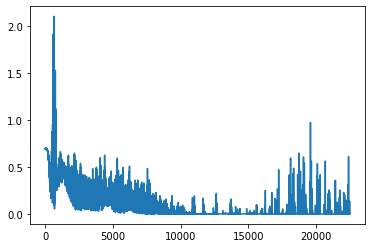

In [158]:
plt.plot(LOSS)

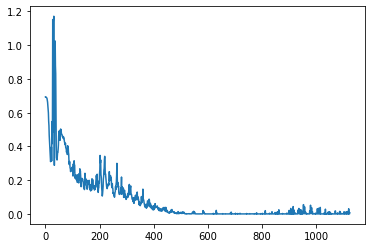

In [159]:
plt.plot(torch.tensor(LOSS).view(-1,20).mean(1))

In [160]:
print("F1_test: %.5f"%(get_f1(X_test, y_test)))

tensor(1)
tensor(1)
F1_test: 0.84614
